## ISDS 7070 Deliverable 2
**Names: Raquel Domingos, Dikshanta KC, Patrick Kilshaw 
--22nd June 2021 ** 

In [1]:
# import packages here.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
import dexplot as dxp
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
# Figures inline and set visualization style
%matplotlib inline
sns.set()

In [2]:
#data imported
df_data = pd.read_csv("la_loans.csv")

EDA - Distribution and Outliers - Tukey's method defined as a funtion to identify possibe and probable outliers
#References: https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-1-4ece5098b755 


In [3]:
#Tukey's method
def tukeys_method(df, variable):
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = 1.5*iqr
    outer_fence = 3*iqr
    
    #inner fence lower and upper end
    inner_fence_le = q1-inner_fence
    inner_fence_ue = q3+inner_fence
    
    #outer fence lower and upper end
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence
    
    outliers_prob = []
    outliers_poss = []
    for index, x in enumerate(df[variable]):
        if x <= outer_fence_le or x >= outer_fence_ue:
            outliers_prob.append(index)
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_poss.append(index)
    return outliers_prob, outliers_poss

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148996 entries, 0 to 148995
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   app_accepted                    148996 non-null  int64  
 1   respondent_id                   148996 non-null  object 
 2   agency_name                     148996 non-null  object 
 3   agency_abbr                     148996 non-null  object 
 4   loan_type_name                  148996 non-null  object 
 5   property_type_name              148996 non-null  object 
 6   loan_purpose_name               148996 non-null  object 
 7   owner_occupancy_name            148996 non-null  object 
 8   loan_amount_000s                148996 non-null  int64  
 9   preapproval_name                148996 non-null  object 
 10  applicant_ethnicity_name        148996 non-null  object 
 11  co_applicant_ethnicity_name     148996 non-null  object 
 12  applicant_race_n

In [5]:
#Binning of Categorical Variables - Shows the relative frequency at which each category has a loan application accepted or denied
# Category values which have similar proportions of accepted and denied were binned together.
#Categorical variables were limited to five unique values to limit exessive model training times.
df_data['agency_abbr'] = df_data['agency_abbr'].replace({'FRS' : 'OCC'})
df_data['applicant_race_name_1'] = df_data['applicant_race_name_1'].replace({'Native Hawaiian or Other Pacific Islander' : 'White'})
df_data['applicant_race_name_1'] = df_data['applicant_race_name_1'].replace({'Asian' : 'White'})
df_data['applicant_race_name_1'] = df_data['applicant_race_name_1'].replace({'Black or African American' : 'American Indian or Alaska Native'})
df_data['co_applicant_race_name_1'] = df_data['co_applicant_race_name_1'].replace({'Native Hawaiian or Other Pacific Islander' : 'White'})
df_data['co_applicant_race_name_1'] = df_data['co_applicant_race_name_1'].replace({'Asian' : 'White'})
df_data['co_applicant_race_name_1'] = df_data['co_applicant_race_name_1'].replace({'Black or African American' : 'American Indian or Alaska Native'})

In [6]:
# Fill missing values with mean column values 
#data.fillna(data.mean(), inplace=True)
# calculates the mean of each column with missing data and assigns it to an object
avg_applicant_income_000s = df_data["applicant_income_000s"].mean()
avg_population = df_data["population"].mean()
avg_minority_population = df_data["minority_population"].mean()
avg_hud_median_family_income  = df_data["hud_median_family_income"].mean()
avg_tract_to_msamd_income = df_data["tract_to_msamd_income"].mean()
avg_number_of_owner_occupied_units = df_data["number_of_owner_occupied_units"].mean()
avg_number_of_1_to_4_family_units  = df_data["number_of_1_to_4_family_units"].mean()

#Replaces missing datapoints with the average (mean) for that column
df_data["applicant_income_000s"].replace(np.nan, avg_applicant_income_000s, inplace=True)
df_data["population"].replace(np.nan, avg_population, inplace=True)
df_data["minority_population"].replace(np.nan, avg_minority_population, inplace=True)
df_data["hud_median_family_income"].replace(np.nan, avg_hud_median_family_income, inplace=True)
df_data["tract_to_msamd_income"].replace(np.nan, avg_tract_to_msamd_income, inplace=True)
df_data["number_of_owner_occupied_units"].replace(np.nan, avg_number_of_owner_occupied_units, inplace=True)
df_data["number_of_1_to_4_family_units"].replace(np.nan, avg_number_of_1_to_4_family_units, inplace=True)

EDA - Distribution and Outliers - Probable and Possible Outliers Identified for each variable. Probable Outliers Removed.
#All numeric variables, other than hud_median_family_income, contained outliers.

In [7]:

#All probable outlierz assumed to be an error.
df_data_outliers_included = df_data

probable_outliers_LA, possible_outliers_LA = tukeys_method(df_data, "loan_amount_000s")
df_data = df_data.drop(df_data.index[probable_outliers_LA])
probable_outliers_AS, possible_outliers_AS = tukeys_method(df_data, "applicant_sex")
df_data = df_data.drop(df_data.index[probable_outliers_AS])
probable_outliers_AI, possible_outliers_AI = tukeys_method(df_data, "applicant_income_000s")
df_data = df_data.drop(df_data.index[probable_outliers_AI])
probable_outliers_P, possible_outliers_P = tukeys_method(df_data, "population")
df_data = df_data.drop(df_data.index[probable_outliers_P])
probable_outliers_MP, possible_outliers_MP = tukeys_method(df_data, "minority_population")
df_data = df_data.drop(df_data.index[probable_outliers_MP])
probable_outliers_MSAMD, possible_outliers_MSAMD = tukeys_method(df_data, "tract_to_msamd_income")
df_data = df_data.drop(df_data.index[probable_outliers_MSAMD])
probable_outliers_OO, possible_outliers_OO = tukeys_method(df_data, "number_of_owner_occupied_units")
df_data = df_data.drop(df_data.index[probable_outliers_OO])
probable_outliers_FU, possible_outliers_FU = tukeys_method(df_data, "number_of_1_to_4_family_units")
df_data = df_data.drop(df_data.index[probable_outliers_FU])

In [8]:
# deleted applicant_race_name_2 and co_applicant_race_name_2 which each had over 99% missing data
del df_data['applicant_race_name_2']
del df_data['co_applicant_race_name_2'] 

#Deleted agency_name, used agency_abbr in its place. Deleted applicant_sex_name, used applicant_sex in its place.
del df_data['agency_name'] 
del df_data['applicant_sex_name']

#drop respondent_id column
del df_data['respondent_id']

#Purchaser_type_name was dropped as it appears to be dependent on the outcome variable. See mosaic plot analysis in milestone 1.
del df_data['purchaser_type_name']

In [9]:
del df_data_outliers_included['applicant_race_name_2']
del df_data_outliers_included['co_applicant_race_name_2'] 
del df_data_outliers_included['agency_name'] 
del df_data_outliers_included['applicant_sex_name']
del df_data_outliers_included['respondent_id']
del df_data_outliers_included['purchaser_type_name']

In [10]:
#Numerical Data Saved in a separate data frame
df_data_Numerical = df_data[["loan_amount_000s", "number_of_1_to_4_family_units", "applicant_income_000s", "population", "minority_population", "hud_median_family_income", "tract_to_msamd_income", "number_of_owner_occupied_units"]]

In [11]:
#Feature Seletion - Data normalized and saved in a separate data fram prior to creating dummies
scaler = StandardScaler()
scaler.fit(df_data_Numerical)
normalData = scaler.transform(df_data_Numerical)

In [12]:
#Verification - Predicted variable saved separate from dataframe. Dummy Variables assigned.
y = df_data.app_accepted
y2 = df_data_outliers_included.app_accepted
df_data = df_data.drop('app_accepted', axis=1)
df_data_outliers_included = df_data_outliers_included.drop('app_accepted', axis=1)

#df_data = pd.get_dummies(df_data, columns=['agency_abbr', 'loan_type_name', 'property_type_name', 'loan_purpose_name', 'owner_occupancy_name', 'preapproval_name', 'applicant_ethnicity_name', 'co_applicant_ethnicity_name', 'applicant_race_name_1' , 'co_applicant_race_name_1', 'co_applicant_sex_name', 'hoepa_status_name', 'lien_status_name', "loanAmount", "number_of_1_to_4_family_units", "ApplicantIncome", "population", "minority_population", "hud_median_family_income", "tract_to_msamd_income", "number_of_owner_occupied_units"], drop_first=True)
df_data = pd.get_dummies(df_data, columns=['agency_abbr', 'loan_type_name', 'property_type_name', 'loan_purpose_name', 'owner_occupancy_name', 'preapproval_name', 'applicant_ethnicity_name', 'co_applicant_ethnicity_name', 'applicant_race_name_1' , 'co_applicant_race_name_1', 'co_applicant_sex_name', 'hoepa_status_name', 'lien_status_name'], drop_first=True)
df_data_outliers_included = pd.get_dummies(df_data_outliers_included, columns=['agency_abbr', 'loan_type_name', 'property_type_name', 'loan_purpose_name', 'owner_occupancy_name', 'preapproval_name', 'applicant_ethnicity_name', 'co_applicant_ethnicity_name', 'applicant_race_name_1' , 'co_applicant_race_name_1', 'co_applicant_sex_name', 'hoepa_status_name', 'lien_status_name'], drop_first=True)

In [13]:
#Predictors assigned to object. Train/test split created.
#Predictors Subset
df_data_predictors = df_data[["population", "loan_amount_000s", "number_of_owner_occupied_units", "applicant_income_000s", "number_of_1_to_4_family_units", "minority_population", "tract_to_msamd_income", "agency_abbr_FDIC", "hud_median_family_income"]] #"applicant_ethnicity_name_Information not provided by applicant in mail, Internet, or telephone application", "applicant_ethnicity_name_Not applicable", "preapproval_name_Preapproval was not requested", "agency_abbr_HUD", "owner_occupancy_name_Not owner-occupied as a principal dwelling", "property_type_name_One-to-four family dwelling (other than manufactured housing)" , "agency_abbr_OCC", "co_applicant_race_name_1_White" ,"co_applicant_ethnicity_name_Not Hispanic or Latino","co_applicant_ethnicity_name_Information not provided by applicant in mail, Internet, or telephone application", "applicant_race_name_1_White", "loan_purpose_name_Refinancing", "loan_purpose_name_Home purchase"]]
X = df_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=23)

In [14]:
#Feature Seletion
#references https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

#SelectKBest used to find best features
BestFeatures = SelectKBest(score_func=chi2, k=45) #can do all for k
fit = BestFeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(45,'Score'))  #prints all features ranke by score

                                                Specs          Score
3                                          population  264095.821410
0                                    loan_amount_000s  212712.708335
7                      number_of_owner_occupied_units  135790.497306
2                               applicant_income_000s   89845.259358
8                       number_of_1_to_4_family_units   67837.370574
4                                 minority_population   18632.063533
6                               tract_to_msamd_income   13580.280448
9                                    agency_abbr_FDIC    3693.465364
5                            hud_median_family_income    3240.930375
24  applicant_ethnicity_name_Information not provi...    2877.095179
32               applicant_race_name_1_Not applicable    2617.932142
26            applicant_ethnicity_name_Not applicable    2583.173212
22     preapproval_name_Preapproval was not requested    2207.010106
10                                

In [15]:
#Naive Bayes - Ran using all features remaining after wrangling and explortion.
clf_NB = GaussianNB()
clf_NB.fit(X_train,y_train) 

pred = clf_NB.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, pred), 5))

Accuracy: 0.64317


In [16]:
X = df_data_Numerical
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=23)

In [17]:
#Naive Bayes - Ran using only numerical variables.
clf_NB = GaussianNB()
clf_NB.fit(X_train,y_train) 

pred = clf_NB.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, pred), 5))

Accuracy: 0.57409


In [18]:
X = normalData
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=23)

In [19]:
#Naive Bayes - Ran using only normalized numerical variables.
clf_NB = GaussianNB()
clf_NB.fit(X_train,y_train) 

pred = clf_NB.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, pred), 5))

Accuracy: 0.57409


In [20]:
X = df_data_predictors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=23)

In [21]:
#Naive Bayes - Ran using top 23 predictors according to K-Best Feature Selection.
clf_NB = GaussianNB()
clf_NB.fit(X_train,y_train) 

pred = clf_NB.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, pred), 5))

Accuracy: 0.60379


In [22]:
X = df_data_outliers_included
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.15, random_state=23)

In [23]:
#Naive Bayes - Ran using all features remaining after wrangling and explortion. Outliers added back to the dataframe to see effect.
clf_NB = GaussianNB()
clf_NB.fit(X_train,y_train) 

pred = clf_NB.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, pred), 5))


Accuracy: 0.57105


In [24]:
X = df_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=23)

In [25]:
#Naive Bayes - Confusion Matrix for Best Model
clf_NB = GaussianNB()
clf_NB.fit(X_train,y_train) 

pred = clf_NB.predict(X_test)

#create confusion matrix and print it
confusionMatrix = pd.DataFrame(
    confusion_matrix(y_test, pred),
    columns=['Predicted Disapprove', 'Predicted Approve'],
    index=['True Disapprove', 'True Approve']
)
print(confusionMatrix)
print()
print("Accuracy:", round(accuracy_score(y_test, pred), 5))


                 Predicted Disapprove  Predicted Approve
True Disapprove                  6700               2992
True Approve                     4673               7116

Accuracy: 0.64317


The Naive Bayes model, unlike decision trees which can be tuned using number of estimators or depth, does not have hyper parameters readily available which can be adjusted for model tuning. The best performing model used all 44 variables which remained after wrangling and creating dummy variables. Confusion Matrix Results Below:

Sensitivity:60%
Specificity: 69%
False Positive: 30%
False Negative: 41%
Error:35.68%

In [26]:
scaler = StandardScaler()
scaler.fit(df_data)
normalData = scaler.transform(df_data)

In [27]:
#Run the principal component analysis
pca = PCA()
transformedPCA = pca.fit_transform(normalData)

In [28]:
#Run the principal component analysis
pca = PCA()
transformedPCA = pca.fit_transform(normalData)

print("Explained variance:", pca.explained_variance_)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance ratio:", pca.explained_variance_ratio_.cumsum())
print()

#print the feature weights for your data
print("Feature Weights")

for i in df_data.columns: 
    print(i, end=' ') 

print()
print(abs( pca.components_ ))

#convert feature weights into a dataframe
weights = pd.DataFrame(abs(pca.components_))
weights.columns = df_data.columns


Explained variance: [5.61656276e+00 4.18679992e+00 3.70969638e+00 3.14821343e+00
 2.40284213e+00 2.27945015e+00 2.01867096e+00 1.66447425e+00
 1.50180183e+00 1.31065139e+00 1.19508658e+00 1.18159520e+00
 1.14435974e+00 1.09624883e+00 1.04890936e+00 1.02267291e+00
 1.00710211e+00 9.73137051e-01 9.39678920e-01 8.60236753e-01
 8.18694477e-01 7.10878724e-01 6.26397221e-01 5.90729621e-01
 5.08074698e-01 4.46173065e-01 4.38243106e-01 3.53473289e-01
 3.44560225e-01 3.03569445e-01 2.84329197e-01 2.49924711e-01
 2.27639116e-01 2.18044039e-01 1.74676615e-01 1.13237266e-01
 9.54219842e-02 6.94334151e-02 5.03263071e-02 3.04546361e-02
 2.54892413e-02 7.26226354e-03 5.09092971e-03 1.10767170e-30
 1.99465708e-32]
Explained variance ratio: [1.24811634e-01 9.30393486e-02 8.24371217e-02 6.99598099e-02
 5.33961189e-02 5.06540941e-02 4.48590414e-02 3.69880585e-02
 3.33731409e-02 2.91253830e-02 2.65572940e-02 2.62574877e-02
 2.54300388e-02 2.43609150e-02 2.33089341e-02 2.27259060e-02
 2.23798905e-02 2.1625

We ran the above Principal Component Analysis with above code and imported it to excel file for clearer observation.From the Cumulative explained variance ratio we can see that after the 12th item the difference has fallen down and also it could help explain 77.28% of data. Therefore we would select 12 predictors to our models.  

In [29]:
# To import the finding in excel.
#writer = pd.ExcelWriter('PCA1.xlsx')
#weights.to_excel(writer,index=False)
#writer.save()

After twelve items, PCA showed a cumulative explained variance of 77.28%. A minimum increase in explained variance was seen after this. Given this, these twelve predictors were seen as crucial in predicting loan approval and are as follows: number_of_owner_occupied_units, co_applicant_ethnicity_name, owner_occupancy_name, loan_purpose_name, lien_status_name,preapproval_name, agency_abbr,ApplicantIncome, hoepa_status_name, hud_median_family_income,loanAmount, and loan_type_name.


The Decision Tree below was run with the 12 predictors from PCA analysis.

In [30]:
estimator = DecisionTreeClassifier()
estimator.fit(X_train, y_train)

DecisionTreeClassifier()

In [31]:
#This block of code creates a table of 8 different trees, using the Gini and
# entropy methods of purity checks, prints the accuracy of model
print('depth','gini ','entropy')
for i in range(1,9):
    dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    gini_score = accuracy_score(y_test, pred)
     # Entropy method of purity check
dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i)
dtree.fit(X_train, y_train)
pred = dtree.predict(X_test)
entropy_score = accuracy_score(y_test, pred)
 #Using f-string formatting print
print(f'{i:<6}{round(gini_score,3):<6}{round(entropy_score,3)}')

depth gini  entropy
8     0.695 0.693


In [32]:
#create the final tree with the suggested depth from the above code block
dtree = DecisionTreeClassifier(criterion='entropy', max_depth=5)
dtree.fit(X_train, y_train)

#test the model and calculate the accuracy of prediction
pred = dtree.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, pred),3))

Accuracy: 0.684


Selecting the predictors from PCA and tuning to a depth of 5 achieved an accuracy 68.40% and the following confusion matrix results:

Sensitivity:62% Specificity: 74% False Positive: 34% False Negative: 30% Error:31.63%

In [33]:
#create confusion matrix and print it
confusionMatrix = pd.DataFrame(
    confusion_matrix(y_test, pred),
    columns=['Predicted Disapprove', 'Predicted Approve'],
    index=['True Disapprove', 'True Approve']
)
print(confusionMatrix)
print()

                 Predicted Disapprove  Predicted Approve
True Disapprove                  5984               3708
True Approve                     3086               8703



In [34]:
#create a list of features and orders them 
importances = pd.DataFrame({'predictor':X_train.columns,'importance':np.round(dtree.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
print(importances)
print()

                                            predictor  importance
17  property_type_name_One-to-four family dwelling...       0.286
18                    loan_purpose_name_Home purchase       0.235
9                                    agency_abbr_FDIC       0.207
2                               applicant_income_000s       0.072
4                                 minority_population       0.052
10                                    agency_abbr_HUD       0.031
33                        applicant_race_name_1_White       0.029
12                                    agency_abbr_OCC       0.029
32               applicant_race_name_1_Not applicable       0.018
0                                    loan_amount_000s       0.015
1                                       applicant_sex       0.013
19                      loan_purpose_name_Refinancing       0.007
21  owner_occupancy_name_Owner-occupied as a princ...       0.002
20  owner_occupancy_name_Not owner-occupied as a p...       0.002
42        

In [35]:
ColNames = df_data.columns

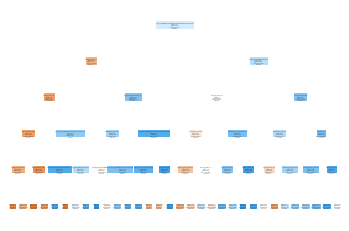

In [36]:
plt.figure()
plot_tree(dtree, filled=True, feature_names=ColNames, class_names=['Yes','No'])
plt.savefig('TreePlot1.pdf')
plt.show()

**Random Forest Classifier**

In [37]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=10)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [38]:
X=df_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=23)

In [39]:
#Random Forest - Model intialized and ran using all features remaining after wrangling and explortion. No tuning or further feature selection performed.  
dtree = RandomForestClassifier(criterion='entropy', max_depth=(18)) # limited to five for calc time purposes
dtree.fit(X_train, y_train)

pred = dtree.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, pred), 5))

Accuracy: 0.70169


In [40]:
X = df_data_Numerical
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=23)

In [41]:
#Random Forest - Ran using only numerical variables.
dtree = RandomForestClassifier(criterion='entropy', max_depth=(18)) # limited to five for calc time purposes
dtree.fit(X_train, y_train)

pred = dtree.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, pred), 5))

Accuracy: 0.62274


In [42]:
X = normalData
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=23)

In [43]:
#Random Forest - Ran using only normalized numerical variables.
dtree = RandomForestClassifier(criterion='entropy', max_depth=(18)) # limited to five for calc time purposes
dtree.fit(X_train, y_train)

pred = dtree.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, pred), 5))

Accuracy: 0.70136


In [44]:
X = df_data_predictors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=23)

In [45]:
#Random Forest - Ran using top 23 predictors according to K-Best Feature Selection.
dtree = RandomForestClassifier(criterion='entropy', max_depth=(18)) # limited to five for calc time purposes
dtree.fit(X_train, y_train)

pred = dtree.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, pred), 5))

Accuracy: 0.64313


In [46]:
X = df_data_outliers_included
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.15, random_state=23)

In [47]:
#Random Forest - Ran using all features remaining after wrangling and explortion. Outliers added back to the dataframe to see effect.
dtree = RandomForestClassifier(criterion='entropy', max_depth=(18)) # limited to five for calc time purposes
dtree.fit(X_train, y_train)

pred = dtree.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, pred), 5))

Accuracy: 0.70438


In [48]:
#Random Forest - Confusion Matrix for Best Model
dtree = RandomForestClassifier(criterion='entropy', max_depth=(18)) # limited to five for calc time purposes
dtree.fit(X_train, y_train)

pred = dtree.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, pred), 5))

#create confusion matrix and print it
confusionMatrix = pd.DataFrame(
    confusion_matrix(y_test, pred),
    columns=['Predicted Disapprove', 'Predicted Approve'],
    index=['True Disapprove', 'True Approve']
)
print(confusionMatrix)
print()
print("Accuracy:", round(accuracy_score(y_test, pred), 5))

Accuracy: 0.70582
                 Predicted Disapprove  Predicted Approve
True Disapprove                  5938               3914
True Approve                     2661               9837

Accuracy: 0.70582


The best performing model using the Random Forest, used all 44 variables which remained after wrangling and creating dummy variables, along with the outliers being added back to the dataframe. Confusion Matrix Results Below:

Sensitivity:78% Specificity: 60% False Positive: 28% False Negative: 31% Error:29.53%



**Randomized Search for Hyperparameters in Random Forest**

In [49]:
from sklearn.model_selection import RandomizedSearchCV  

In [50]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [8, 10, 12, 14, 16, 18, 20],
    'max_features': [1, 2],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
    'n_estimators': [10, 25, 50, 75, 100, 200]
}

In [51]:
model = RandomForestRegressor()

In [52]:
model_random = RandomizedSearchCV(estimator = model, param_distributions = param_grid, n_iter = 30, 
                                  cv = 5, verbose=2, random_state=23, n_jobs = -1)

In [ ]:
# Fit the random search model
model_random.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   42.3s


In [ ]:
model_random.best_params_

In [ ]:
#Create a Gaussian Classifier with new hyper parameters
clf=RandomForestClassifier(n_estimators=100, max_features=2, bootstrap='True')

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

#Random Forest - Confusion Matrix for Best Model
dtree = RandomForestClassifier(criterion='entropy', max_depth=(20)) # limited to five for calc time purposes
dtree.fit(X_train, y_train)

pred = dtree.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, pred), 5))

#create confusion matrix and print it
confusionMatrix = pd.DataFrame(
    confusion_matrix(y_test, pred),
    columns=['Predicted Disapprove', 'Predicted Approve'],
    index=['True Disapprove', 'True Approve']
)
print(confusionMatrix)
print()
print("Accuracy:", round(accuracy_score(y_test, pred), 5))


 Confusion Matrix Results Below:

Sensitivity:79% Specificity: 60% False Positive: 28% False Negative: 31% Error:29.46%

After tuning our Random Forest model we were able to develop a model with 70.60 % accurate which has the highest accuracy rate amoung our model. We have also selected the most appropriate feature in this model with the help of other models we developed. Therefore we would approach our Tuned Random Forest model as the best model we developed.